# Lab 3-2: Plotting the Surface Energy Balance at Kettle Ponds
Written by Daniel Hogan - April, 2023.

Modified by Jessica Lundquist - April, 2023.

Modified by Eli Schwat - January 2024.

### Snowpack Energy Balance Equation 

Consider the snowpack energy balance equation during mid-winter periods when there is no snow melt:

$$ \frac{d}{dt} (U \Delta z) = R_{net} - H_L - H_s + G$$

where

$$R_{net} = LW_{in} - LW_{out} + SW_{in} - SW_{out} $$

and ∆z is the snowpack depth.

In Lab 3-1, we examined the four radiation terms. In this lab, we will estimate the remaining terms. 
We want all measurements to be in units of $W/m^2$. 
The radiation variables are already in these units.
The other variables in the dataset require conversion.

---
### Converting turbulent flux measurements into energy flux units ($W/m^2$)
Without diving too much into the details of the turbulent water vapor (latent heat) flux $H_L$ and sensible heat flux $H_s$, we note that turbulent water vapor flux is measured in units of $g/m^2/s$ and sensible heat flux is measured in units $K/m^2/s$, and are in the dataset as the following variables:

`w_h2o__3m_c` (latent heat flux)

and

`w_tc__3m_c` (sensible heat flux).

---
#### Converting turbulent latent heat flux measurements into energy flux units ($W/m^2$)

To convert `w_h2o__3m_c` (latent heat flux in $g/m^2/s$) to $W/m^2$, we will use the latent heat of sublimation (the sum of the latent heats of fusion and vaporization, $L_{sub} = 2590 J/g$).

$H_l = $ `w_h2o__3m_c` $ * L_{sub}$

and the units work out like this : $\frac{g}{m^2 s} * \frac{J}{g} = \frac{J}{m^2 s} = \frac{W}{m^2}$ (b/c 1 Watt = 1 Joule per second).

---
#### Converting turbulent sensible heat flux measurements into energy flux units ($W/m^2$)

To convert `w_tc__3m_c` (sensible heat flux in units $K m/s$) to $W/m^2$, we will use the specific heat capacity of air ($c_{p}^{air} = 1.005$ $J/K/g$) and the density of air ($\rho_{air} = 1000 g / m^3$). Note that we use the physical constants for air since it is air that is transporting heat away from the snowpack. 

$H_s = $ `w_tc__3m_c` $ * c_{p}^{air} * \rho_{air}$

and the units work out like this: $\frac{K m}{s} * \frac{J}{K g} * \frac{g}{m^3} = = \frac{W}{m^2}$

---

#### Estimating the internal energy term

$$ \frac{dU}{dt} = \rho_s c_p^{ice} \Delta z \frac{d}{dt} \langle T_s \rangle $$

The internal energy term involves estimating the bulk temperature of the snowpack which is a bit challenging, so we will leave it to a future lab. 

For now, we will solve for all the terms in the energy balance equation, and calculate this internal energy term as the residual of the sum of the other terms.

---

In [1]:
import xarray as xr
import numpy as np
import os 
import urllib
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt

### SOS Data

In [2]:
sos_file = "../data/sos_full_dataset_30min.nc"
sos_dataset = xr.open_dataset(sos_file)

### Calculate net radiation

In [3]:
[v for v in sos_dataset.data_vars if v.startswith('Rsw')]

['Rsw_in_9m_d', 'Rsw_out_9m_d', 'Rsw_net_9m_d']

In [4]:
[v for v in sos_dataset.data_vars if v.startswith('Rlw')]

['Rlw_in_9m_d',
 'Rlw_out_9m_d',
 'Rlw_in_9m_uw',
 'Rlw_out_9m_uw',
 'Rlw_net_9m_d',
 'Rlw_net_9m_uw']

Note that we are accounting for the energy balance of the snow surface, so SW and LW radiation *away* from the snow pack are subtracted.

In [5]:
net_radiation = sos_dataset['Rsw_in_9m_d'] - sos_dataset['Rsw_out_9m_d'] + sos_dataset['Rlw_in_9m_d'] - sos_dataset['Rlw_out_9m_d']

### Calculate latent heat flux in energy units

Note that the measurement `w_h2o__3m_c` is latent heat flux *away* from the snow pack, so in terms of snowpack surface energy, positive `w_h2o__3m_c` is energy lost.

In [6]:
latent_heat_sublimation = 2590 #J/g
latent_heat_flux = sos_dataset['w_h2o__3m_c'] * latent_heat_sublimation

### Calculate sensible heat flux in energy units
Note that the measurement `w_tc__3m_c` is sensible heat flux *away* from the snow pack, so in terms of snowpack surface energy, positive `w_h2o__3m_c` is energy lost.

In [7]:
specific_heat_capacity_air = 1.005 # J/K/g
air_density = 1000 # g/m^3                                       
sensible_heat_flux = sos_dataset['w_tc__3m_c'] * specific_heat_capacity_air * air_density

# negating the measurements
sensible_heat_flux = - sensible_heat_flux

### Calculate snow surface temperature change in energy units

In [8]:
specific_heat_capacity_ice = 2.1 # J/K/g
density_ice = 9.1e5 #g/m^3
surface_layer_thickness = 0.01 #m

# calculate the forward difference of T_ss
delta_Tss_over_delta_t = np.gradient(
    sos_dataset['Tsurf_c'],
    30*60 # number of seconds in thirty minutes
)

# np.gradient returns a numpy array. We can create an XArray dataarray from the returned numpy array so that we can use the same plotting functions for all of our terms.
delta_Tss_over_delta_t = xr.DataArray(
    delta_Tss_over_delta_t,
    coords = sos_dataset['Tsurf_c'].coords,
    dims = sos_dataset['Tsurf_c'].dims
)
snow_surface_temp_change = delta_Tss_over_delta_t * specific_heat_capacity_ice * density_ice * surface_layer_thickness

## Plot energy balance terms for a 5 day period in April 

Look at some other time periods too. The radiometers went out a lot, but this stretch of time had good radiometer data.

Identify the ground heat flux (already in the correct units)

In [9]:
ground_heat_flux =  - sos_dataset['Gsoil_d']

Text(0, 0.5, 'Energy flux (W/m^2)')

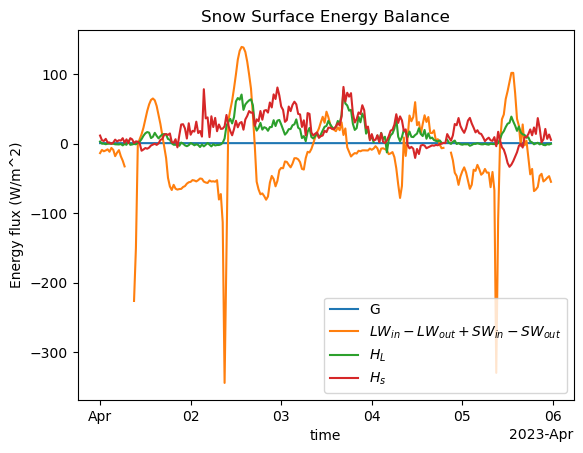

In [10]:
time_slice = slice('20230401', '20230405')
ground_heat_flux.sel(time=time_slice).plot(label=r'G')
net_radiation.sel(time=time_slice).plot(label=r'$LW_{in} - LW_{out} + SW_{in} - SW_{out}$')
latent_heat_flux.sel(time=time_slice).plot(label=r'$H_L$')
sensible_heat_flux.sel(time=time_slice).plot(label=r'$H_s$')
plt.legend()
plt.title('Snow Surface Energy Balance')
plt.ylabel('Energy flux (W/m^2)')

## Calculate the average hourly daily energy balance for December - March
This period represents "mid-winter", when snow cover is continuous and no snow melt occurs.

We calculate the average value for each term for each hour. This is often called a "diurnal cycle" or "composite" plot.

I find this is easier to do with a Pandas Dataframe than an Xarray dataset, so I create a Pandas Dataframe with our results first.

In [11]:
# Create the dataframe with the terms we calculated. Assign the dataframe index as the timestamps.
energy_balance_df = pd.DataFrame({
        'net_radiation': net_radiation,
        'latent_heat_flux': latent_heat_flux,
        'sensible_heat_flux': sensible_heat_flux,
        'ground_heat_flux': ground_heat_flux,
},
    index = net_radiation.time
)

# Isolate data from December through March
energy_balance_df = energy_balance_df.loc['20221201': '20230331']

energy_balance_df.head()

,net_radiation,latent_heat_flux,sensible_heat_flux,ground_heat_flux
2022-12-01 00:00:00,NaN,-2.738287,4.247066,11.246106
2022-12-01 00:30:00,-37.944641,-3.415608,-36.489785,10.969131
2022-12-01 01:00:00,-46.407837,-3.408481,0.993175,10.704575
2022-12-01 01:30:00,-47.259842,-4.678287,8.542756,10.478374
2022-12-01 02:00:00,NaN,-4.264122,12.751584,10.376369


In [12]:
# Create a column representing the hour of the day
energy_balance_df['hour_of_day'] = energy_balance_df.index.hour

# Groupby the hour_of_day and take the median (instead of the mean, this will handle any outliers, which appear in the radiation data)
energy_balance_df_diurnal_average = energy_balance_df.groupby('hour_of_day').median()

Because we want to plot the _snowpack_ energy balance, we will make the sensible and latent heat fluxes negative (see above).

In [13]:
energy_balance_df_diurnal_average['latent_heat_flux'] = - energy_balance_df_diurnal_average['latent_heat_flux']
energy_balance_df_diurnal_average['sensible_heat_flux'] = - energy_balance_df_diurnal_average['sensible_heat_flux']

Text(0, 0.5, 'Energy flux (W/m^2)')

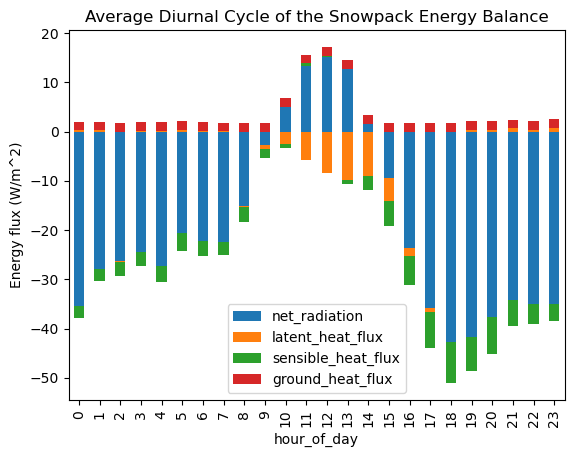

In [14]:
energy_balance_df_diurnal_average.plot.bar(stacked=True)
plt.title('Average Diurnal Cycle of the Snowpack Energy Balance')
plt.ylabel('Energy flux (W/m^2)')

# Estimating the residual
According to our simplified energy balance equation, 

$$ \frac{dU}{dt} = R_{net} - H_L - H_s + G$$

the terms should combine to balance. We have not calculated the internal energy change term yet (we will in the next lab).
However, if this balance is true, it is logical that the _residual_ of the four terms we have estimated should equal the internal energy change term.
Let's calculate the _residual_ of our energy balance and add it to our plot - i.e., let's estimate 

$$ \frac{dU}{dt} $$ 

with our other terms. Note that we already negated the latent and sensible heat flux terms, so they are _added_ in the math below.

In [15]:
energy_balance_df_diurnal_average['dU/dt (est. as residual)'] = - (
    energy_balance_df_diurnal_average['net_radiation'] 
    + energy_balance_df_diurnal_average['latent_heat_flux'] # we already negated latent heat flux above, so we need to un-negate it here
    + energy_balance_df_diurnal_average['sensible_heat_flux'] # we already negated sensible heat flux above, so we need to un-negate it here
    + energy_balance_df_diurnal_average['ground_heat_flux']
)

Did we do the math correctly? We can check by making sure the sum of all the energy balance terms is 0.

In [16]:
energy_balance_df_diurnal_average.sum(axis=1)

hour_of_day
0     0.0
1     0.0
2     0.0
3     0.0
4     0.0
5     0.0
6     0.0
7     0.0
8     0.0
9     0.0
10    0.0
11    0.0
12    0.0
13    0.0
14    0.0
15    0.0
16    0.0
17    0.0
18    0.0
19    0.0
20    0.0
21    0.0
22    0.0
23    0.0
dtype: float64

Text(0, 0.5, 'Energy flux (W/m^2)')

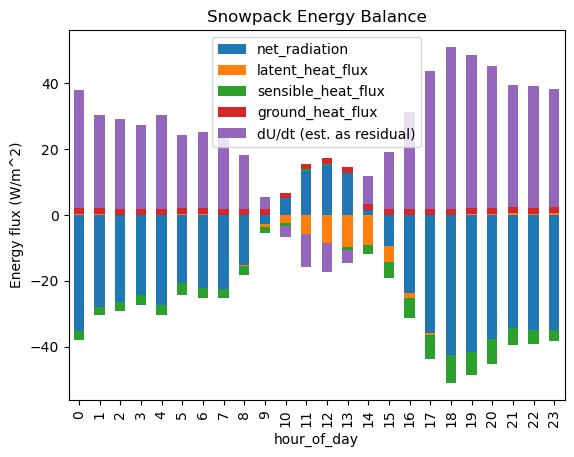

In [17]:
energy_balance_df_diurnal_average.plot.bar(stacked=True)
plt.title('Snowpack Energy Balance')
plt.ylabel('Energy flux (W/m^2)')

What do we think of this residual? Say that we assumed the internal energy change term is equal to the residual. Does our plot make sense?

Let's save this calculation so we can use it in future labs

In [18]:
energy_balance_df_diurnal_average.to_pickle("energy_balance_df_diurnal_average.pkl")